# Prerequisites

In [448]:
# pip install PyMuPDF                    # (install PyMuPDF for extracting info from PDF files)
# pip install tika                       # (install tika for extracting paragraphs from PDF files)
# pip install spacy==2.2.0               # (install spacy for lemmatization)
# conda install gensim                   # (intall gesim for topic modelling)
# pip install pyLDAvis                   # (install pyLDAvis for topic modelling visulisation)
# conda install -c conda-forge pyldavis  # (if you use aconda to install pyLADvis)

In [449]:
import pandas as pd
import numpy as np
import nltk; nltk.download('stopwords') 
from nltk.corpus import stopwords      # import stop words
stop_words = stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


In [450]:
import re
from pprint import pprint

# glob for extracting the directories of metadata
import glob

# PyMuPDF
import fitz

# tika
import tika               
from tika import parser   

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Visualisation
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Import pdf files, data wrangling and overview

In [451]:
# Extract the directories of the PDF files
pdf_dir = "D:\LEON\Business Analytics\Study\9. Business Project\Data set\Crossrail"
pdf_files = glob.glob("%s/*.pdf" % pdf_dir)
pdf_files[3]

'D:\\LEON\\Business Analytics\\Study\\9. Business Project\\Data set\\Crossrail\\British_Railways_(London)_Bill_Lords_(By_Order)_20_Jan_1988.pdf'

In [452]:
# Use PyMuPDF to extract all info of the PDF files (text, title, date, etc)
list_metadata = []
for i in pdf_files:
    with fitz.open(i) as doc:
        info = doc.metadata       
        text = ''
        for page in doc:
            text+= page.getText()
        info['Content'] = text
    list_metadata.append(info)

mupdf: cmsOpenProfileFromMem failed


In [453]:
df = pd.DataFrame(list_metadata)
df.head(3)

,format,title,author,subject,keywords,creator,producer,creationDate,modDate,trapped,encryption,Content
0,PDF 1.7,,Katherine A Bloomfield,,,Microsoft® Word 2019,Microsoft® Word 2019,D:20201012160043+01'00',D:20201012160043+01'00',,None,10-Year Transport Plan \n \n6. \n \nMr. Geoffr...
1,PDF 1.4,,,,,pdftk 2.02 - www.pdftk.com,itext-paulo-155 (itextpdf.sf.net-lowagie.com),D:20190730052236Z,D:20190730052236Z,,None,"House of Commons \nTransport, Local Government..."
2,PDF 1.4,Microsoft Word - 021588,stellent,,,PScript5.dll Version 5.2,Acrobat Distiller 5.0.5 (Windows),D:20041008151844+01'00',D:20041008151844+01'00',,None,AnNew deal for Transport: Better for everyone ...


In [454]:
print(df.loc[0, 'Content']) # content of the first document

10-Year Transport Plan 
 
6. 
 
Mr. Geoffrey Clifton-Brown  (Cotswold) 
If he will make a statement on the recommendations in the recent report 
from the Transport Select Committee relating to the investment programme 
in the 10-year transport plan. [63716] 
 
The Secretary of State for Transport (Mr. Alistair Darling) 
We will respond to the Select Committee report in the normal way. In 
addition, as I said when I was  appointed to this job, 1 am looking at 
all the Department's policies, and I will keep the House informed of 
policy developments as and when appropriate. 
 
Mr. Clifton-Brown 
Paragraph 84 of the Select Committee's stingingly critical report on the 
Government's 10-year plan states: "The Committee remains concerned about 
the lack of clarity surrounding the financing of the rail improvements in 
the 10 Year Plan…The lack of any detailed implementation plan is a major 
barrier to improving the railways." When can we expect from the 
Government some interim targets and a

In [455]:
df = df.drop_duplicates(subset = 'Content') # drop duplicate rows
df = df.dropna(subset=['Content']) # drop rows whose text content is NaN
df['Word_count'] = df ['Content'].str.count(' ') + 1
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 0 to 228
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   format        229 non-null    object
 1   title         229 non-null    object
 2   author        229 non-null    object
 3   subject       229 non-null    object
 4   keywords      229 non-null    object
 5   creator       229 non-null    object
 6   producer      229 non-null    object
 7   creationDate  229 non-null    object
 8   modDate       229 non-null    object
 9   trapped       229 non-null    object
 10  encryption    5 non-null      object
 11  Content       229 non-null    object
 12  Word_count    229 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 25.0+ KB


### Word count

In [456]:
# Word count
df['Word_count'].sum( )

11132849

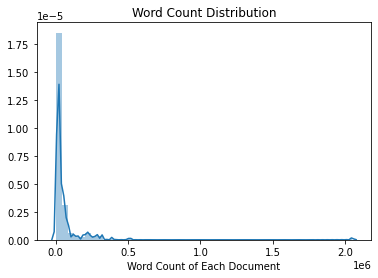

In [457]:
# Word count distribution
import seaborn as sns
ax1 = sns.distplot(df['Word_count'])
ax1.set(title = 'Word Count Distribution',
        xlabel = 'Word Count of Each Document');

# Tokenization

In [458]:
data = df.Content.values.tolist()

In [459]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
data_words[:1]

[['year',
  'transport',
  'plan',
  'mr',
  'geoffrey',
  'clifton',
  'brown',
  'cotswold',
  'if',
  'he',
  'will',
  'make',
  'statement',
  'on',
  'the',
  'recommendations',
  'in',
  'the',
  'recent',
  'report',
  'from',
  'the',
  'transport',
  'select',
  'committee',
  'relating',
  'to',
  'the',
  'investment',
  'programme',
  'in',
  'the',
  'year',
  'transport',
  'plan',
  'the',
  'secretary',
  'of',
  'state',
  'for',
  'transport',
  'mr',
  'alistair',
  'darling',
  'we',
  'will',
  'respond',
  'to',
  'the',
  'select',
  'committee',
  'report',
  'in',
  'the',
  'normal',
  'way',
  'in',
  'addition',
  'as',
  'said',
  'when',
  'was',
  'appointed',
  'to',
  'this',
  'job',
  'am',
  'looking',
  'at',
  'all',
  'the',
  'department',
  'policies',
  'and',
  'will',
  'keep',
  'the',
  'house',
  'informed',
  'of',
  'policy',
  'developments',
  'as',
  'and',
  'when',
  'appropriate',
  'mr',
  'clifton',
  'brown',
  'paragraph',
  '

# Remove Stopwords, Make Bigrams and Trigrams, and Lemmatisation

In [460]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [461]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [462]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#increase the maximum length of text that the parser or NER can process
nlp.max_length = 13000000 #

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['year', 'transport', 'plan', 'cotswold', 'make', 'statement', 'recommendation', 'recent', 'report', 'transport', 'committee', 'relate', 'investment', 'transport', 'state', 'transport', 'committee', 'report', 'normal', 'way', 'addition', 'say', 'appoint', 'job', 'look', 'department', 'policy', 'keep', 'house', 'informed', 'policy', 'development', 'appropriate', 'committee', 'stingingly', 'critical', 'report', 'government', 'year', 'remain', 'concerned', 'lack', 'clarity', 'surround', 'financing', 'rail', 'lack', 'detailed', 'implementation', 'plan', 'major', 'barrier', 'improve', 'railway', 'expect', 'government', 'interim', 'target', 'define', 'work', 'programme', 'indeed', 'government', 'respond', 'report', 'revise', 'plan', 'produce', 'matter', 'smuggle', 'summer_recess', 'parliament', 'sit', 'report', 'table', 'normal', 'way', 'house', 'sit', 'time', 'particularly', 'conservative', 'government', 'funding', 'railway', 'indeed', 'everything_else', 'arrange', 'annual', 'basis', 'gove

#  Create the Dictionary and Corpus needed for Topic Modeling

In [463]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 4), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 3), (24, 1), (25, 3), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 2), (32, 10), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 3), (43, 4), (44, 1), (45, 1), (46, 1), (47, 6), (48, 1), (49, 1), (50, 1), (51, 1), (52, 3), (53, 3), (54, 2), (55, 1), (56, 2), (57, 1), (58, 3), (59, 4), (60, 2), (61, 1), (62, 2), (63, 2), (64, 1), (65, 3), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 2), (72, 1), (73, 1), (74, 1), (75, 3), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 3), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 3), (101, 1), (102, 1), (103, 1), (104, 2), (105, 2), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

# Building LDA Model, Hyperameter (k) tuning

In [464]:
# the fisrt model. gensim.models.LdaMulticore is Online LDA in Python, using all CPU cores to parallelize and speed up model training.
# if it does not work for you, try the gensim.models.ldamodel.LdaModel which is an equivalent, but more straightforward and single-core implementation.
k = 20
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics = k)

In [465]:
# create the function for computing the coherence score of different models with different number of topics.
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word,num_topics = k)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [466]:
# apply the function, it might take a long time.
limit=100; start=0; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)

In [467]:
# plot the coherence score against number of topics
x = range(start, limit, step)
list_num_topics = [i for i in x]
df_coherence = pd.DataFrame({'Number_of_Topics': list_num_topics, 'Coherence_Score': coherence_values})
fig1 = px.line(df_coherence, x = 'Number_of_Topics', y="Coherence_Score", title = 'Coherence score against number of topics')
fig1.update_layout(autosize=False, width=1000, height=400)
fig1.update_traces(mode = "lines + markers")
fig1.show()

In [469]:
# num of topics = 30 to get the highest coherence socre
k = 35
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics = k)

# Apply the trained model to predict the topics of paragraphs

### Extract paragraphs from documents

In [470]:
# create the function for metadata extraction from documents
def info(i):
    with fitz.open (i) as doc:
        info = doc.metadata
        return info

# create the function for paragraph extraction from documents
def paragraphs_extraction(i):
    j = parser.from_file(i)
    m = j['content']
    n = m.split('\n \n') # split the documents by new lines, if the corpus changes and the paragraphs are not splitted correctly , try to repalce '\n \n' by '\n \n'
    n = [w.replace('\n', '') for w in n]
    return n

In [733]:
list_paragraphs = []
for i in pdf_files:
    with fitz.open(i) as doc:
        info = doc.metadata
        info['paragraphs'] = paragraphs_extraction(i) 
    list_paragraphs.append(info)                      # if it fails, try to rerun it
df_paragraph = pd.DataFrame(list_paragraphs)               # dataframe containing paragraphs of each documents
df_paragraph['document_id'] = df_paragraph.index             # set the index as the document id

# split the list of paragraphs into rows
df_para  = df_paragraph.set_index(['document_id'])['paragraphs'].apply(pd.Series)\
                                         .stack()\
                                         .reset_index(level=1, drop=True)
df_para = df_para.reset_index()
df_para = df_para.rename(columns={0: "paragraphs"})
df_para['paragraphs'] = [w.replace('\t', '') for w in df_para['paragraphs']] # remove tab in texts
df_para = df_para[df_para['paragraphs'].str.strip() !=''] # drop rows whose text content is NaN
df_para = df_para.dropna(subset=['paragraphs']) 
df_para = df_para.reset_index()
df_para

,index,document_id,paragraphs
0,0,0,10-Year Transport Plan
1,1,0,6.
2,2,0,Mr. Geoffrey Clifton-Brown (Cotswold) If he w...
3,3,0,The Secretary of State for Transport (Mr. Alis...
4,4,0,Mr. Clifton-Brown Paragraph 84 of the Select C...
...,...,...,...
11626,11849,228,Mr. Spellar That was rather ungallant of Oppos...
11627,11850,228,Chris Grayling (Epsom and Ewell) The Governme...
11628,11851,228,"Mr. Spellar That is fine cheek, coming from a ..."
11629,11852,228,Andrew Bennett (Denton and Reddish) Does my r...


In [472]:
df_para.loc[11629, 'paragraphs']

'Andrew Bennett  (Denton and Reddish) Does my right hon. Friend accept that, although commuters in Greater Manchester are prepared to put up with a deterioration in  the service while the west coast main line is being upgraded, they want the certainty that services will be restored to at least their former level, if not improved? '

### Predict topics of paragraphs

In [473]:
# create function for topic extraction
def topic_extraction(i):
    doc = i.split()
    doc_vector = lda_model.id2word.doc2bow(doc)
    doc_topics = lda_model[doc_vector]
    return doc_topics

In [476]:
# predict topics of paragraphs
list_topic_para = []
dictionary_topic_para = {}
for i in df_para['paragraphs']:
    doc = i.split()
    doc_vector = lda_model.id2word.doc2bow(doc)
    doc_topics = lda_model[doc_vector]
    doc_dic = Convert(doc_topics, dictionary_topic_para)
    list_topic_para.append(doc_dic)
    df_topic_para = pd.DataFrame(list_topic_para)
df_topic_para1 = pd.merge(df_para, df_topic_para, how = 'left', left_index=True, right_index=True)
df_topic_para1 = df_topic_para1.drop(columns = 'index')
df_topic_para1

,document_id,paragraphs,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,34
0,0,10-Year Transport Plan,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,...,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571
1,0,6.,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,...,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571
2,0,Mr. Geoffrey Clifton-Brown (Cotswold) If he w...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926893,NaN
3,0,The Secretary of State for Transport (Mr. Alis...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.927266,NaN
4,0,Mr. Clifton-Brown Paragraph 84 of the Select C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.974795,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11626,228,Mr. Spellar That was rather ungallant of Oppos...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.984814,NaN
11627,228,Chris Grayling (Epsom and Ewell) The Governme...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964661,NaN
11628,228,"Mr. Spellar That is fine cheek, coming from a ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11629,228,Andrew Bennett (Denton and Reddish) Does my r...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.957462,NaN


# Overview of topics

### The most frequent 10 words of each topic

In [477]:
pprint(lda_model.print_topics())

[(3,
  '0.010*"would" + 0.009*"transport" + 0.008*"take" + 0.008*"make" + '
  '0.007*"go" + 0.007*"train" + 0.006*"year" + 0.005*"work" + 0.005*"say" + '
  '0.005*"service"'),
 (28,
  '0.011*"would" + 0.011*"transport" + 0.008*"service" + 0.006*"rail" + '
  '0.006*"say" + 0.006*"make" + 0.005*"road" + 0.005*"public" + 0.005*"year" + '
  '0.005*"passenger"'),
 (1,
  '0.011*"transport" + 0.009*"would" + 0.009*"service" + 0.007*"rail" + '
  '0.006*"public" + 0.006*"say" + 0.006*"road" + 0.005*"make" + 0.005*"need" + '
  '0.005*"year"'),
 (33,
  '0.015*"transport" + 0.010*"would" + 0.008*"service" + 0.008*"rail" + '
  '0.007*"make" + 0.007*"government" + 0.006*"take" + 0.006*"need" + '
  '0.006*"road" + 0.005*"also"'),
 (27,
  '0.014*"transport" + 0.009*"would" + 0.007*"use" + 0.006*"work" + '
  '0.006*"system" + 0.006*"local" + 0.006*"year" + 0.006*"rail" + '
  '0.005*"service" + 0.005*"say"'),
 (11,
  '0.019*"transport" + 0.007*"work" + 0.007*"rail" + 0.006*"make" + '
  '0.006*"governmen

### Topic distribution across documents

In [478]:
# create the function for converting a list of tuples into a dictionary
def Convert(tup, di):
    di = dict(tup)
    return di

# topic distribution over documents
list_topic = []
dictionary_topic = {}
for d in texts:
    bow = id2word.doc2bow(d)
    belong = lda_model[bow]                        # generate a list of tuples of topic distribution of a document
    belong_dic = Convert(belong, dictionary_topic) # convert the list of tuples into a dictionary
    list_topic.append(belong_dic)           
                      
df_topic_distribution = pd.DataFrame(list_topic)   # convert the list of dictionaries into a dataframe
df_topic = pd.merge(df, df_topic_distribution, how = 'left', left_index=True, right_index=True) # merge with info of documents
df_topic.drop(['format','creator', 'producer', 'keywords', 'trapped', 'encryption'], axis = 1)

,title,author,subject,creationDate,modDate,Content,Word_count,4,7,9,...,13,31,34,10,18,20,1,12,27,28
0,,Katherine A Bloomfield,,D:20201012160043+01'00',D:20201012160043+01'00',10-Year Transport Plan \n \n6. \n \nMr. Geoffr...,1437,0.170632,0.014941,0.019160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,,,D:20190730052236Z,D:20190730052236Z,"House of Commons \nTransport, Local Government...",292641,0.029026,NaN,0.025977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Microsoft Word - 021588,stellent,,D:20041008151844+01'00',D:20041008151844+01'00',AnNew deal for Transport: Better for everyone ...,67602,NaN,NaN,0.017007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,Katherine A Bloomfield,,D:20200429153449+01'00',D:20200429153449+01'00',British Railways (London) Bill Lords (By Order...,26519,0.052353,0.100675,0.023285,...,0.038310,0.010061,0.036837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,Katherine A Bloomfield,,D:20201012144724+01'00',D:20201012144724+01'00',British Railways Bill \n \nOrder for Second Re...,3167,0.068143,0.297041,0.016835,...,0.047155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,,Katherine A Bloomfield,,D:20201012164224+01'00',D:20201012164224+01'00',Transport: London Underground \n \nLord Bridge...,512,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,,Katherine A Bloomfield,,D:20201012164258+01'00',D:20201012164258+01'00',Transport: Rail and Air Travel \n \nWhat is mi...,5173,0.021494,NaN,0.014899,...,NaN,0.015501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,,Katherine A Bloomfield,,D:20201012155409+01'00',D:20201012155409+01'00',Tube Investment \n \n[Relevant documents: Seve...,59658,0.070761,NaN,0.026877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,,Katherine A Bloomfield,,D:20201012163723+01'00',D:20201012163723+01'00',Waterloo Station \n \n11:00:00 \n \nSusan Kra...,4714,0.120691,NaN,NaN,...,0.011682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Topic distribution of the whole corpus
As shown below there are only 8 topics with topic distribution above the threshold (1/K);
according to the PTBI proposed by Marchetti and Puranam (2020), the 8 topics are the salient topics worth interpreting.
However, we extracted 35 topics and the 8 topics are not enough to interpret all the documents, so we prefer to interpret all the topics

In [480]:
topic_distribution = df_topic_distribution.sum()/df_topic_distribution.sum().sum()
topics_distribution = pd.DataFrame({'topic_id': topic_distribution.index, 'topic_distribution': topic_distribution, 
                                    'Not_less_than_threshold': topic_distribution >= 1/k})


topics_distribution.sort_values(by = 'topic_distribution', ascending = False)

,topic_id,topic_distribution,Not_less_than_threshold
33,33,0.241042,True
17,17,0.151321,True
4,4,0.056164,True
5,5,0.051927,True
25,25,0.041890,True
9,9,0.039276,True
19,19,0.034832,True
24,24,0.033754,True
10,10,0.030897,True
2,2,0.025859,False


In [481]:
fig2 = px.bar(topics_distribution, x='topic_id', y='topic_distribution',title='Topic distribution of the whole corpus')
fig2.update_layout(autosize=False, width=1000, height=300)
fig2.show()

### Salient topics in each document
I define the salient topics in each document as the topics with probability > 1/k. In other words, the probablity of the salient topic should be more than the random probability

In [482]:
salient_filter = df_topic_distribution >= 1/k
df_salient_topics = df_topic_distribution[salient_filter]
df_salient_topics

,4,7,9,14,16,17,19,21,22,24,...,13,31,34,10,18,20,1,12,27,28
0,0.170632,NaN,NaN,0.064555,NaN,0.311710,0.064944,0.031222,0.041524,0.080126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.029026,NaN,NaN,0.051378,0.106222,0.135849,0.107015,0.082865,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,0.170599,0.042533,0.182118,0.059546,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.052353,0.100675,NaN,NaN,NaN,0.041417,NaN,NaN,NaN,0.311454,...,0.038310,NaN,0.036837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.068143,0.297041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.094362,...,0.047155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,NaN,NaN,NaN,NaN,NaN,0.404852,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,NaN,NaN,NaN,NaN,0.056375,0.189123,NaN,0.035787,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,0.070761,NaN,NaN,NaN,NaN,0.150594,0.035082,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,0.120691,NaN,NaN,0.038711,NaN,0.097745,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Salient topics in each paragraph

In [743]:
df_salient_topics_para = df_topic_para1.iloc[:, 2:][salient_filter]
df_salient_topics_para

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,NaN,NaN,NaN,NaN,0.028571,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028571,NaN
1,NaN,NaN,NaN,NaN,0.028571,0.028571,NaN,NaN,NaN,NaN,...,0.028571,0.028571,NaN,NaN,NaN,0.028571,NaN,NaN,0.028571,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926893,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.927266,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.974795,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Topic interpretation
To interpret the topics, I combined the word frequncy demonstrated by pyLDAvis with prototypical documents or paragraphs suggested by PTBI proposed by Marchetti and Puranam (2020)

### Word frequency of each topic

In [275]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, sort_topics = False )
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.003572 -0.000664       1        1   2.273159
1      0.003666  0.000175       2        1   0.747964
2     -0.001032  0.002272       3        1   0.247145
3     -0.004524  0.003294       4        1   2.402315
4      0.002049 -0.001591       5        1   3.161092
5      0.001855 -0.000639       6        1   1.134390
6     -0.001559 -0.001264       7        1   4.328910
7     -0.001206  0.000149       8        1   1.001783
8      0.002845  0.002958       9        1   0.067319
9     -0.004620 -0.001738      10        1   9.901554
10    -0.005649 -0.000468      11        1   9.049398
11     0.002066 -0.000879      12        1   1.565768
12    -0.001660  0.002121      13        1   1.044805
13     0.000414  0.001050      14        1   0.581627
14     0.000423 -0.000806      15        1   3.517376
15    -0.000555 -0.000777      16        1   1.993722
16    -0.002341 -0.001635      17        1   3.365777
17     0.001089  0.000123      18        1   0.806727
18     0.003305  0.001667      19        1   0.590501
19     0.000126  0.002889      20        1   0.114658
20    -0.006211 -0.002769      21        1   7.792620
21     0.004587 -0.003460      22        1   5.644750
22     0.003810  0.002138      23        1   1.196689
23    -0.000650 -0.000024      24        1   0.766908
24    -0.009049  0.000494      25        1   9.163124
25     0.001321 -0.000995      26        1   3.047664
26     0.000304  0.000206      27        1   2.368300
27     0.008621  0.002105      28        1   1.782258
28     0.007817 -0.003764      29        1  17.291442
29    -0.001670 -0.000169      30        1   3.050253, topic_info=           Term          Freq         Total Category  logprob  loglift
280   transport  58802.000000  58802.000000  Default  30.0000  30.0000
297       would  45019.000000  45019.000000  Default  29.0000  29.0000
215        rail  30704.000000  30704.000000  Default  28.0000  28.0000
156        make  26122.000000  26122.000000  Default  27.0000  27.0000
298        year  24464.000000  24464.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
9          also    537.291001  18240.603210  Topic30  -5.5290  -0.0349
193        plan    545.693444  18814.175516  Topic30  -5.5135  -0.0504
240         say    587.255800  22187.872027  Topic30  -5.4401  -0.1419
159         may    510.815707  18984.868864  Topic30  -5.5795  -0.1254
1715       cost    516.718682  20896.929521  Topic30  -5.5681  -0.2099

[2740 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
12523      1  0.013032  abatement
12523      2  0.013032  abatement
12523      4  0.039097  abatement
12523      5  0.039097  abatement
12523      6  0.013032  abatement
...      ...       ...        ...
42094     26  0.022950   ﬁnancial
42094     27  0.022950   ﬁnancial
42094     28  0.022950   ﬁnancial
42094     29  0.091800   ﬁnancial
42094     30  0.022950   ﬁnancial

[17504 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

### Prototypical texts for each topic
I followed the method of extraction of prototypical text suggested by PTBI proposed by Marchetti and Puranam (2020). Its heart lies in that for parameter L (probability that a document belongs to a topic), at least 1/L documents with probablity that they belong to the topic >= L are needed to interpret the topics, this method tries to find out the opitimal value of L to maximize the percentage of interpretable topics (Marchetti and Puranam, 2020, p. 20)

In [594]:
List_num_doc = [x for x in range(1, 20, 1)] # generate a list of 1/L (minimum number of documents to interpret a topic)
list_L = [1/x for x in List_num_doc]        # generate a list of L

In [599]:
# create the function for computing the percentage of potentially interpretable topics against parameter L
def perc(i, df):
    list_num_topics = []
    for j in df:                                  
        topic_filter = df[j] >= i         
        m = df[j][topic_filter].count()           
        list_num_topics.append(m)                                             
        count1 = sum(map(lambda x : x >= 1/i, list_num_topics))                                     
        perc1 = count1 / k
    return(perc1)

The following chart shows that the percentage of potentially interpretable topics for “high enough” levels of L is not large enough, so the paragraph-based interpretation can be explored. 

In [666]:
list_perc1 = []
for i in list_L:
    num = perc(i, df_topic_distribution)
    list_perc1.append(num)

df_L1 = pd.DataFrame({'Parameter L': list_L, 'Percentage of interpretable topics': list_perc1})
fig_L1 = px.line(df_L1, x = 'Parameter L', y="Percentage of interpretable topics", title = 'Value selection for parameter L (document-based)')
fig_L1.update_layout(autosize=False, width=1200, height=400)
fig_L1.update_traces(mode = "lines + markers")
fig_L1.show()

The following chart shows that when L = 0.5, the the percentage of interpretable topics is 100%, so we set L = 0.5 - ie, each topic needs at least 2(1/L) paragraphs to be interpreted.

In [602]:
df_topic_para2 = df_topic_para1.drop(['document_id', 'paragraphs'], axis = 1)
list_perc2 = []
for i in list_L:
    num = perc(i, df_topic_para2)
    list_perc2.append(num)

df_L2 = pd.DataFrame({'Parameter L': list_L, 'Percentage of interpretable topics': list_perc2})
fig_L2 = px.line(df_L2, x = 'Parameter L', y="Percentage of interpretable topics", title = 'Value selection for parameter L (paragraph-based )')
fig_L2.update_layout(autosize=False, width=1200, height=400)
fig_L2.update_traces(mode = "lines + markers")
fig_L2.show()

### Prototypical paragraphs of each topic
As we analysed shown above, for each topic we need to find 2 prototypical paragraphs with the highest probablity that they belong to the topic to interpret the topic. 
Then we could combine the prototypical paragraphs with the word frequncy demonstrated by pyLDAvis to interpret the topics.

In [683]:
list_text = []
df_topic_para3 = df_topic_para1.iloc[:, 2:]
for i in range(0, k):
    dict_text = {}
    dict_text['topic_id'] = df_topic_para1.columns[i + 2]
    dict_text['prototypical_para'] = df_topic_para1.nlargest(2, [i])['paragraphs']
    list_text.append(dict_text)
df_proto = pd.DataFrame(list_text)
df_proto

,topic_id,prototypical_para
0,0,9808 o\ Question 14 Economic Categories as ...
1,1,10779 Dr. John Pugh (Southport) (LD) In his...
2,2,7496 “We think that an important part of th...
3,3,"8930 Mrs. May In any tender process, bids a..."
4,4,"10983 Well, we needed a Conservative think-..."
5,5,8092 Reference has been made to overcrowdin...
6,6,"10938 What happened? By June 2002, car traf..."
7,7,"2747 (2) The Board, during and for the purp..."
8,8,5005 Mr. Michael Shersby (Uxbridge) I had ...
9,9,4551 The Committee therefore first consider...


# Build topic model on paragraphs

In [168]:
# tokenization
data2 = df_para.paragraphs.values.tolist()
data_words2 = list(sent_to_words(data2))

In [169]:
# Bigram & Trigram
bigram2 = gensim.models.Phrases(data_words2, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram2 = gensim.models.Phrases(bigram2[data_words2], threshold=100)  
bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
trigram_mod2 = gensim.models.phrases.Phraser(trigram2)

In [170]:
# Remove Stop Words
data_words_nostops2 = remove_stopwords(data_words2)

# Form Trigrams
data_words_trigrams2 = make_trigrams(data_words_nostops2)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized2 = lemmatization(data_words_trigrams2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [171]:
# Create Dictionary
id2word2 = corpora.Dictionary(data_lemmatized2)

# Create Corpus
texts2 = data_lemmatized2

# Term Document Frequency
corpus2 = [id2word2.doc2bow(text) for text in texts]

In [173]:
# Gensim LDA model
lda_model2 = gensim.models.LdaMulticore(corpus=corpus2, id2word=id2word2, num_topics = 30)

In [174]:
# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=lda_model2, texts=data_lemmatized2, dictionary=id2word2, coherence='c_v')
coherence_lda2 = coherence_model_lda2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)


Coherence Score:  0.610932426384829


In [175]:
# Visualize the topics
vis2 = pyLDAvis.gensim_models.prepare(lda_model2, corpus2, id2word2, sort_topics = False)
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.000665  0.000080       1        1   3.472499
1     -0.001380  0.000098       2        1   1.951263
2     -0.003989  0.000195       3        1   1.882334
3      0.006435 -0.002624       4        1   6.793689
4      0.000870 -0.000168       5        1   1.916012
5      0.003098 -0.000894       6        1   3.917579
6      0.004780 -0.002649       7        1  12.806271
7      0.000800  0.002470       8        1   1.724141
8      0.001973  0.000780       9        1   0.600462
9      0.000324  0.001902      10        1   0.817991
10     0.002621  0.000573      11        1   1.271921
11     0.000797 -0.001053      12        1   4.109343
12    -0.002033  0.001030      13        1   0.570382
13    -0.000468  0.003341      14        1   1.505726
14     0.004804 -0.000795      15        1   4.232424
15    -0.002201 -0.002575      16        1   8.875641
16     0.000470  0.000455      17        1   2.800311
17    -0.002701 -0.000941      18        1   2.434383
18    -0.001271 -0.003624      19        1   2.924746
19    -0.001546 -0.000863      20        1   1.717180
20     0.000857  0.000244      21        1   4.704072
21    -0.003034 -0.000014      22        1   0.585725
22    -0.007497 -0.000572      23        1   7.599880
23     0.000813 -0.000102      24        1   1.560456
24    -0.002911 -0.001243      25        1   7.726862
25     0.001758  0.002964      26        1   0.314595
26     0.004465  0.004219      27        1   3.200693
27     0.000123 -0.001053      28        1   3.464526
28    -0.000563 -0.000979      29        1   3.493573
29    -0.006060  0.001800      30        1   1.025320, topic_info=          Term          Freq         Total Category  logprob  loglift
0    transport  55957.000000  55957.000000  Default  30.0000  30.0000
119      would  43650.000000  43650.000000  Default  29.0000  29.0000
32        rail  30567.000000  30567.000000  Default  28.0000  28.0000
172    service  28522.000000  28522.000000  Default  27.0000  27.0000
2         make  27195.000000  27195.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
228     system    174.065077  19030.595273  Topic30  -5.5647  -0.1142
427       road    184.959993  21724.312117  Topic30  -5.5040  -0.1859
128        new    170.377812  18935.270213  Topic30  -5.5861  -0.1306
66      public    177.631419  21938.142024  Topic30  -5.5444  -0.2361
214      train    163.836370  19584.868065  Topic30  -5.6252  -0.2035

[2770 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
552        1  0.034664      access
552        2  0.024622      access
552        3  0.017469      access
552        4  0.063687      access
552        5  0.020220      access
...      ...       ...         ...
1         27  0.026957        year
1         28  0.033010        year
1         29  0.031656        year
1         30  0.008680        year
41744      7  0.332059  yearfigure

[19055 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])